# 1 - Multi-armed bandits (3 pts.)
In this part of the homework, you will reproduce some of the results in Chapter 2 of the Sutton and Barto
book.

Suppose that you have a 10-armed bandit problem—i.e., an agent has to select among a set of 10
different actions, each of which yields a different (average) reward. In particular, suppose that the actual
reward associated with each action a ∈ {1, . . . , 10} is a random variable following a Gaussian distribution
with mean Q(a) and variance 1.  
You will compare the average reward received by:  
>• A greedy policy, where the estimated reward for each action a is initialized as Qˆ(a) = 0;  
    • A greedy policy, where the estimated reward for each action a is initialized as Qˆ(a) = 5;  
    • An ε-greedy policy, with ε = 0.1, where the estimated reward for each action a is initialized as Qˆ(a) = 0;  
    • An ε-greedy policy, with ε = 0.01, where the estimated reward for each action a is initialized as Qˆ(a) = 0;  
    • The UCB policy. 

To do this

1. Select the average values Q(a), a ∈ {1, . . . , 10} , at random from a normal distribution with mean 0 and variance 1;
2. Run the policies listed above for 1, 000 steps and compute, for each policy, the reward received at each time step;
3. Repeat the two previous steps 2, 000 times;
4. Compute the reward obtained at each time step by each of the policies averaged across the 2, 000 trials.

**Question 1. Using the results from the procedure outlined above, plot the average reward obtained with each policy during the 1, 000 steps in a single plot. Comment the differences observed.**

### Notes

A greedy policy is an ε-greedy policy with ε = 0;  
NumPy provides a normal distribution: https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html;

Logic is given by:


![image.info](./pictures/bandit.png)


Previous image is from the *Reinforcement Learning: An Introduction* book, by Sutton and Barto, found in:  
http://incompleteideas.net/sutton/book/the-book-2nd.html

In [704]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns

import copy
# from numpy.random import default_rng

## Generic Bandit class

In [854]:
# Attempt a simple bandit

class Bandit(object):
    
    # Variable initialization
    def __init__(self, n_actions=10, iterations=1000, use_ucb=True, initial_estimate=0.0, 
                 epsilon=0.0, c=0.0):
        
        # Set the size of action space
        self.n_actions = int(n_actions)
        
        # Initial the true Q(a) value array
        self.q_actions = np.random.normal(loc=0.0, scale=np.sqrt(1), size=n_actions)
        
        # Value of picking an action
        self.rewards = None
        
        # Initial estimate for Q^(a)
        self.estimates = np.array([float(initial_estimate) for i in np.arange(self.n_actions)])
        
        # Times chosen each action
        self.times_chosen = np.zeros(self.n_actions)
        
        # Number of iteration
        self.max_iterations = int(iterations)
        
        # Number of timesteps
        self.timestep = 0
        
        # Whether we used or not the UCB
        self.is_UCB = bool(use_ucb)
        
        # Epsilon for greedy - greedy is 0
        self.epsilon = float(epsilon)
        
        # Constant C value for UCB
        self.c_value = float(c)
        
        # Total reward
        self.total_reward = 0.0
        
        # Records
        self.records = None
        
    # Generate rewards from true Q(a)
    def __generate_step_rewards(self):
        temp_rewards = np.zeros(self.n_actions)
        for i in np.arange(self.n_actions):
            temp_rewards[i] = np.random.normal() + self.q_actions[i]
        self.rewards = temp_rewards

    # Get Q(a) at timestep n+1
    def __update_action_value__(self, action_index, reward):
        next_qa = self.estimates[action_index] + (reward - self.estimates[action_index]) / self.times_chosen[action_index]
        return next_qa
        
    # Pick action A at t+1
    def __select_action_ucb__(self):
        ucb_values = np.zeros(self.n_actions)
        for i in np.arange(self.n_actions):
            ucb_values[i] = self.estimates[i] + self.c_value * np.sqrt(np.log(self.timestep) / self.times_chosen[i])
    
        next_action = np.argmax(ucb_values)

        return next_action
    
    
    def __select_action_epsilon__(self):
        if np.random.random() <= self.epsilon:
            known_action = np.argmax(self.estimates)
            
            # Generate probs for each action
            prob_actions = np.random.standard_normal(size=self.n_actions)
            prob_actions[known_action] = -999
            return np.argmax(prob_actions)
        else:
            return np.argmax(self.estimates)
        
        
    def __complete_records__(self, total_reward, action_picked, reward_received):
        new_df = pd.DataFrame({'Cumulative Reward': total_reward,
                               'Picked Action': action_picked,
                               'Reward Received': reward_received}, 
                              index=np.arange(1, len(total_reward)+1))
        new_df['Average Reward'] = new_df['Cumulative Reward'].values / np.arange(1, len(total_reward)+1)
        
        return new_df
            
            
    def iterate(self):
        # 1 - Initialize Q(a) -> done on class initialization
        # 2 - Initialize rewards from normal distribution with mean = Q(a)
        # 3 - If is UBC, pick each action exactly once first
        # 4 - Pick action based on the UCB or greedy
        # 5 - Get reward for action selected
        # 6 - Update counter of selection for action selected
        # 7 - Get new Q(a) for the selected action
        
        # Initialize the records
        records_total_reward = np.array([])
        records_action_picked = np.array([])
        records_reward_received = np.array([])
        
        if self.is_UCB:
            # Pick each action once
            for action in np.arange(self.n_actions):
                
                # Get rewards at current time step
                self.__generate_step_rewards()
                
                # Update counters
                self.times_chosen[action] += 1
                self.timestep += 1
                
                # Update estimate for the chosen action
                self.estimates[action] = self.__update_action_value__(action_index=action, 
                                                                      reward=self.rewards[action])                
                self.total_reward += self.rewards[action]

                records_total_reward = np.append(records_total_reward, self.total_reward)
                records_action_picked = np.append(records_action_picked, action)
                records_reward_received = np.append(records_reward_received, self.rewards[action])
        
        for iteration in np.arange(self.max_iterations):
            
            # Pick action
            picked_action = None
            if self.is_UCB:
                picked_action = self.__select_action_ucb__()
            else:
                picked_action = self.__select_action_epsilon__()
            
            # Update timestep and action counter
            self.times_chosen[picked_action] += 1
            self.timestep += 1
            
            # Generate rewards at current time step from a normal distribution with mean=Q(a)
            self.__generate_step_rewards()
            
            # Pick the action
            self.estimates[picked_action] = self.__update_action_value__(action_index=picked_action, 
                                                                         reward=self.rewards[picked_action])
            #print('Estimates {}'.format(self.estimates))
            self.total_reward += self.rewards[picked_action]
            
            records_total_reward = np.append(records_total_reward, self.total_reward)
            records_action_picked = np.append(records_action_picked, picked_action)
            records_reward_received = np.append(records_reward_received, self.rewards[picked_action])
        
        self.records = self.__complete_records__(records_total_reward, records_action_picked,
                                                 records_reward_received)
        #print(self.estimates)
        return self.records
    
    
    def plot_rewards(self, title=None):
        if self.records is not None:
            
            fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(20, 8))

            axs[0].plot(self.records['Cumulative Reward'])
            axs[0].set_xlabel('Iterations')
            axs[0].set_ylabel('Cumulative Reward')
            axs[0].set_title('Cumulative Reward over Iterations')

            axs[1].plot(self.records['Average Reward'])
            axs[1].set_xlabel('Iterations')
            axs[1].set_ylabel('Average Reward')
            axs[1].set_title('Average Reward over Iterations')
            
            axs[2].plot(self.records['Reward Received'])
            axs[2].set_xlabel('Iterations')
            axs[2].set_ylabel('Reward Received')
            axs[2].set_title('Reward Received over Iterations')
            
            fig.suptitle(title, fontsize=14)

            plt.show()

## Test example

In [857]:
# Instantiate the Bandit class for UCB with C=0.2 (for test)

bandit = Bandit(iterations=2000, use_ucb=True, epsilon=0.0, c=1.0, initial_estimate=0.0)
bandit.iterate()

,Cumulative Reward,Picked Action,Reward Received,Average Reward
1,1.191046,0.0,1.191046,1.191046
2,2.440593,1.0,1.249547,1.220297
3,4.001333,2.0,1.560740,1.333778
4,2.277026,3.0,-1.724307,0.569257
5,1.710287,4.0,-0.566739,0.342057
...,...,...,...,...
2006,2756.476940,2.0,1.771119,1.374116
2007,2758.977503,2.0,2.500563,1.374677
2008,2760.536247,2.0,1.558744,1.374769
2009,2761.594034,2.0,1.057787,1.374611


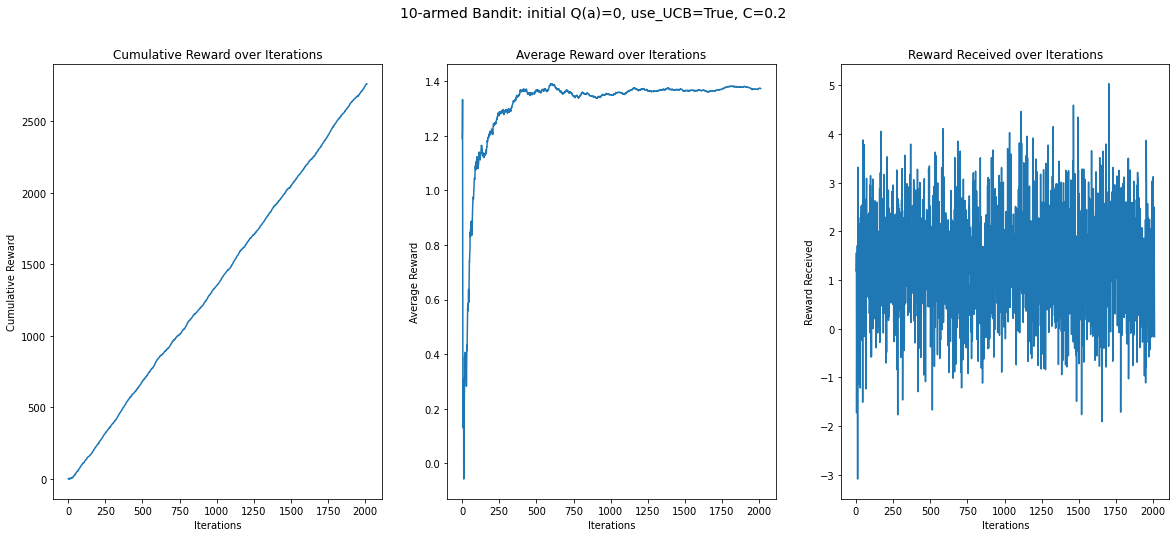

In [858]:
# Plot the Cumulative Reward and Average Reward (for test)

bandit.plot_rewards('10-armed Bandit: initial Q(a)=0, use_UCB=True, C=0.2')

## MultiBandit class

In [859]:
# Define a class for running multiple instances of a 10-armed bandit problem

class MultiBandit(object):
    
    def __init__(self, experiment_iter=2000, bandit_iter=1000, number_actions=10,
                 use_UCB=False, c=0.0, epsilon=0.0, initial_estimate=0.0, column=None):
        
        # Number of bandits to run
        self.experiment_iter = experiment_iter
        
        # Iterations of each bandit
        self.bandit_iter = bandit_iter
        
        # Action space size for each bandit
        self.number_actions = number_actions
        
        # If use UCB
        self.use_UCB = use_UCB
        
        # C value for the UCB
        self.c = c
        
        # Epsilon for epsilon-greedy
        self.epsilon = epsilon
        
        # Initial Q^(a) values
        self.initial_estimate = initial_estimate
        
        # Bandit dictionary collection
        self.bandit_records = {}
        
        # Column to analyze
        self.column = column
        
        # Averaged results
        self.results = None

    def __multi_bandit__(self, experiment_iter, bandit_iter, number_actions=10, use_UCB=False, 
                         c=0, epsilon=0, initial_estimate=0):

        for i in tqdm.notebook.trange(self.experiment_iter):
            temp_bandit = Bandit(n_actions=self.number_actions, iterations=self.bandit_iter, 
                                 epsilon=self.epsilon, use_ucb=self.use_UCB, c=self.c, 
                                 initial_estimate=self.initial_estimate)
            temp_bandit.iterate()

            self.bandit_records['Run {:0004d}'.format(i+1)] = temp_bandit

        return


    # Get the averaged results for a column
    def __average_results__(self, dictionary, column):
        if self.column is not None:
            current_results = {}
            for run in tqdm.notebook.trange(len(dictionary)):
                current_results[list(dictionary.keys())[run]] = dictionary[list(dictionary.keys())[run]].records[column]

            return pd.DataFrame(current_results)
        else:
            return
        
        
    def iterate(self):
        self.__multi_bandit__(experiment_iter=self.experiment_iter, bandit_iter=self.bandit_iter, 
                              number_actions=self.number_actions, use_UCB=self.use_UCB, epsilon=self.epsilon, 
                              initial_estimate=self.initial_estimate)
        self.results = self.__average_results__(self.bandit_records, self.column)
        
        return self.results
        

In [860]:
# A greedy policy, where the estimated reward for each action a is initialized as Qˆ(a) = 0;

greedy_bandit_q0 = MultiBandit(use_UCB=False, epsilon=0.0, initial_estimate=0.0, column='Average Reward')
greedy_bandit_q0.iterate()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

,Run 0001,Run 0002,Run 0003,Run 0004,Run 0005,Run 0006,Run 0007,Run 0008,Run 0009,Run 0010,...,Run 1991,Run 1992,Run 1993,Run 1994,Run 1995,Run 1996,Run 1997,Run 1998,Run 1999,Run 2000
1,0.020154,-0.821281,-0.414185,-0.788079,-1.628258,0.857916,1.351626,-1.882140,-0.168563,0.500099,...,0.872219,1.887677,3.369293,-1.051963,-0.808141,1.051181,2.589535,-1.043220,-2.680975,2.108122
2,1.181566,-0.188833,0.110461,0.579405,-2.152514,0.007827,0.943874,-0.331720,0.395215,0.958765,...,0.527518,2.412417,3.240218,0.369982,-1.085489,1.195840,2.094395,0.343264,-1.290880,1.419530
3,1.036086,0.465952,0.511377,0.590197,-1.106996,-0.391217,0.876992,-0.852755,0.493295,1.058920,...,0.410416,2.074499,2.587913,0.174003,-0.442878,0.990548,1.873001,0.644750,-0.135341,1.291673
4,0.858117,0.915043,0.229405,0.763916,-0.491492,0.086415,0.784321,-0.841974,0.324412,0.969986,...,0.528294,2.676592,2.643697,0.091638,-0.683943,0.493875,1.667056,1.094534,-0.128505,1.247057
5,0.944004,1.053067,0.314139,0.807796,-0.286829,-0.065073,0.833778,-0.792518,0.342017,0.509571,...,0.253139,2.532417,2.750329,0.178390,-0.444215,0.465679,1.544063,1.817004,0.143731,1.342885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0.374594,1.330552,0.879226,0.043381,0.605868,0.593873,1.075605,1.318901,0.964748,0.213108,...,0.405365,1.555202,3.205121,0.409491,1.365977,0.604213,1.301148,1.275510,0.550533,0.877505
997,0.373073,1.331020,0.882194,0.041908,0.606518,0.592800,1.075303,1.318478,0.965265,0.211763,...,0.406301,1.554776,3.207885,0.409642,1.364726,0.603352,1.300420,1.274616,0.549518,0.879423
998,0.375757,1.329876,0.882861,0.041755,0.605906,0.592973,1.073639,1.317404,0.964159,0.211554,...,0.405915,1.553702,3.209267,0.408970,1.365435,0.602801,1.299896,1.274972,0.551895,0.881331
999,0.376068,1.329659,0.882416,0.040484,0.606063,0.593666,1.072869,1.316483,0.963737,0.212913,...,0.406837,1.554172,3.210843,0.408807,1.366433,0.603315,1.301384,1.276276,0.553152,0.880684


In [861]:
# A greedy policy, where the estimated reward for each action a is initialized as Qˆ(a) = 5;

greedy_bandit_q5 = MultiBandit(use_UCB=False, epsilon=0, initial_estimate=5, column='Average Reward')
greedy_bandit_q5.iterate()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

,Run 0001,Run 0002,Run 0003,Run 0004,Run 0005,Run 0006,Run 0007,Run 0008,Run 0009,Run 0010,...,Run 1991,Run 1992,Run 1993,Run 1994,Run 1995,Run 1996,Run 1997,Run 1998,Run 1999,Run 2000
1,1.259218,0.816542,2.128353,0.473842,-0.593790,3.728622,-0.254594,1.325877,0.535697,2.983305,...,1.666201,0.129596,1.569018,-1.044364,0.342870,1.898540,0.536937,0.010481,0.880391,0.656677
2,-0.813607,-0.082426,0.659707,0.758372,-0.079062,1.850759,-0.143007,1.028381,-0.374629,0.700669,...,1.106769,0.919161,-0.505740,-0.337622,-1.450572,0.805754,-0.372527,1.086655,2.315873,-0.497622
3,-0.365651,-0.105403,0.940272,0.687942,0.090513,0.944360,-0.546646,0.170950,-0.428391,0.991734,...,0.937251,-0.069652,-0.971578,-0.877898,-1.168444,0.507105,-0.564209,0.589555,2.597644,-0.279289
4,-0.874702,0.191522,0.407486,0.344327,0.679087,0.926213,-0.549650,-0.146353,-0.597825,0.972911,...,-0.199605,-0.281195,-0.614487,-0.269668,-1.124866,0.682170,-0.370624,0.603615,2.014534,-0.354212
5,-0.893351,-0.019937,0.122205,0.352007,0.714726,0.928027,-0.411015,0.173959,-0.421257,1.034979,...,0.135970,-0.001066,-1.078240,-0.408467,-1.671067,0.126680,-0.364884,0.762611,1.732883,-0.825773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,1.612954,1.643452,2.141138,1.457070,1.775828,1.910010,1.806185,1.452393,1.258099,2.538386,...,1.583175,0.859424,2.077698,2.703892,1.009023,1.479118,0.160501,1.370828,2.726629,0.909247
997,1.611927,1.644870,2.141798,1.457782,1.776276,1.910878,1.807177,1.453889,1.258335,2.539381,...,1.583464,0.859561,2.077913,2.704034,1.009202,1.478170,0.160673,1.372362,2.725985,0.910508
998,1.614054,1.645753,2.143575,1.456120,1.775807,1.910239,1.807360,1.453374,1.257088,2.539415,...,1.582833,0.859773,2.077860,2.704491,1.010310,1.479041,0.161403,1.374355,2.727360,0.910160
999,1.613779,1.645134,2.143522,1.455237,1.774822,1.910269,1.806448,1.453401,1.256478,2.539776,...,1.583071,0.859390,2.077880,2.706822,1.010457,1.478738,0.161233,1.373426,2.728107,0.909986


In [862]:
# An ε-greedy policy, with ε = 0.1, where the estimated reward for each action a is initialized as Qˆ(a) = 0;  

egreedy_bandit_e01 = MultiBandit(use_UCB=False, epsilon=0.1, initial_estimate=0, column='Average Reward')
egreedy_bandit_e01.iterate()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

,Run 0001,Run 0002,Run 0003,Run 0004,Run 0005,Run 0006,Run 0007,Run 0008,Run 0009,Run 0010,...,Run 1991,Run 1992,Run 1993,Run 1994,Run 1995,Run 1996,Run 1997,Run 1998,Run 1999,Run 2000
1,-0.497917,-1.649088,-1.787286,-0.218419,1.876419,0.225855,-0.286921,-2.105064,1.482206,0.752916,...,1.314540,-0.867445,-1.657502,-0.120111,0.271750,1.448372,-3.260521,0.817314,0.800287,0.682980
2,-0.117447,-0.865640,-0.762822,-0.301408,2.227775,0.743929,0.183479,-1.536191,1.815255,-0.757750,...,1.469846,0.396006,-1.641832,0.617301,0.565001,1.618859,-1.488815,1.107509,1.023224,-1.018825
3,-0.455029,-0.583468,0.186328,0.255332,1.769105,0.760839,-0.140782,-0.395312,1.287212,-0.246195,...,1.408747,0.408841,-0.197503,0.562094,0.463487,1.202740,-0.694399,0.625811,0.621255,-1.576074
4,-0.236920,-0.645180,0.225701,0.639060,1.372621,0.624788,-0.103575,0.137141,1.043770,0.596334,...,1.507986,-0.049414,0.124431,0.874393,0.668618,1.358810,-0.968049,0.599629,0.427526,-1.038851
5,0.084016,-0.482070,0.425453,1.029373,0.971998,0.916050,-0.108013,0.782106,1.124850,0.330071,...,1.248460,0.252226,0.366278,1.028240,0.673327,1.415333,-0.908320,0.467734,0.266968,-1.292662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0.808478,1.310566,1.267810,1.415337,1.495903,0.798057,1.651409,1.646698,1.264749,1.542831,...,1.669750,1.837113,1.435867,0.993359,2.233052,1.469471,1.509087,1.218917,0.697896,0.130391
997,0.808565,1.312022,1.268017,1.416389,1.495943,0.800354,1.652289,1.647618,1.266376,1.542457,...,1.670166,1.836520,1.435820,0.993816,2.232448,1.467935,1.509462,1.219487,0.698706,0.131646
998,0.810236,1.311202,1.269076,1.416696,1.496639,0.800008,1.654089,1.647553,1.263173,1.545273,...,1.669790,1.837336,1.437308,0.994916,2.232531,1.467565,1.508569,1.221262,0.700073,0.132944
999,0.808902,1.312507,1.268511,1.417051,1.496825,0.800034,1.654621,1.648062,1.263205,1.546240,...,1.670389,1.837438,1.437692,0.994809,2.232935,1.467530,1.507884,1.222283,0.699566,0.133349


In [863]:
# An ε-greedy policy, with ε = 0.01, where the estimated reward for each action a is initialized as Qˆ(a) = 0;  

egreedy_bandit_e001 = MultiBandit(use_UCB=False, epsilon=0.001, initial_estimate=0, column='Average Reward')
egreedy_bandit_e001.iterate()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

,Run 0001,Run 0002,Run 0003,Run 0004,Run 0005,Run 0006,Run 0007,Run 0008,Run 0009,Run 0010,...,Run 1991,Run 1992,Run 1993,Run 1994,Run 1995,Run 1996,Run 1997,Run 1998,Run 1999,Run 2000
1,0.156182,-3.195485,0.909334,0.032239,-3.031365,0.549437,-5.010044,-0.940708,1.356969,0.640287,...,0.074953,-0.481020,2.100332,-1.353425,2.088210,-0.104800,-3.302420,-0.155587,-1.415763,-1.862236
2,-0.425654,-3.179511,1.279160,0.412637,-2.458057,-0.608997,-0.176198,-0.944030,1.230904,0.568295,...,-0.231451,-0.518135,0.429831,-0.347464,1.048595,-0.201344,-2.152537,0.523588,-0.949488,-1.167450
3,0.026000,-1.624314,1.417646,0.413068,-1.591771,-0.726072,0.137729,-0.653666,1.232217,0.573878,...,-0.128324,-0.019894,0.480774,-0.099447,0.742730,0.890433,-1.886065,0.509427,-0.778829,-0.204940
4,0.039721,-0.905326,1.249774,0.333876,-1.374162,-0.455520,0.105103,-0.364377,1.414486,0.413666,...,0.253885,0.292228,0.577958,-0.508020,0.561631,1.241792,-1.171458,0.580144,-0.837848,-0.256011
5,0.370669,-0.478264,1.245889,0.362348,-0.960462,-0.415670,-0.013743,-0.166733,1.279450,0.359431,...,0.271858,0.181977,0.501658,-0.235806,0.507707,1.061033,-0.739697,1.122677,-1.376534,0.037180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0.847748,1.297608,0.802121,0.575456,0.193055,0.985814,1.058365,2.075966,0.238962,0.416294,...,0.899751,0.658650,0.705967,1.207249,0.732834,1.178674,1.297813,0.907981,1.212692,1.025144
997,0.848751,1.296672,0.801646,0.575903,0.194040,0.985155,1.057772,2.075536,0.238331,0.417162,...,0.901035,0.658942,0.704413,1.207543,0.731043,1.177710,1.298940,0.908113,1.213531,1.025026
998,0.847637,1.296216,0.803166,0.575430,0.193199,0.984965,1.058258,2.075646,0.236845,0.417621,...,0.903699,0.659252,0.705247,1.207392,0.730554,1.178605,1.297721,0.908703,1.212192,1.024989
999,0.848573,1.296641,0.803971,0.576571,0.192999,0.984912,1.057906,2.075977,0.238248,0.415214,...,0.904546,0.660095,0.705063,1.207832,0.730371,1.178130,1.296125,0.909322,1.209757,1.025907


In [864]:
# The UCB policy. C = 1

ucb_bandit_1 = MultiBandit(use_UCB=True, c=1, initial_estimate=0, column='Average Reward')
ucb_bandit_1.iterate()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

,Run 0001,Run 0002,Run 0003,Run 0004,Run 0005,Run 0006,Run 0007,Run 0008,Run 0009,Run 0010,...,Run 1991,Run 1992,Run 1993,Run 1994,Run 1995,Run 1996,Run 1997,Run 1998,Run 1999,Run 2000
1,-1.791123,1.306567,-0.642777,1.356506,1.655371,-0.405347,1.063206,0.335713,2.038151,-1.188470,...,0.152045,-4.078930,1.928353,-1.052258,1.158580,-0.326566,-0.390529,0.329834,-0.844411,-1.892503
2,-0.391662,0.680695,-0.229806,0.266476,1.974674,0.825992,0.855307,0.913152,0.736099,-0.651405,...,0.871606,-1.769676,0.729769,-0.471391,2.017543,-0.000641,-0.206419,-0.774617,-0.109644,-0.533208
3,0.383557,0.254382,0.127823,1.085782,0.480898,0.410993,1.851605,0.064322,1.609398,-0.252771,...,-0.402948,-1.052420,1.062696,-0.459321,0.612750,-0.402525,1.205420,-1.066282,0.266266,-0.584406
4,-0.065012,0.309108,0.217283,0.196557,0.675136,0.822468,1.455587,-0.022597,1.299213,0.049055,...,-0.245335,-1.633208,0.346517,0.034710,0.486750,-0.310900,1.010120,-1.613708,0.158317,-0.198096
5,0.185527,0.501257,0.904243,0.300335,0.548309,0.972694,0.876312,-0.062341,1.055046,0.607936,...,-0.352960,-1.117598,0.630990,0.355763,0.708044,-0.332471,0.695777,-1.277526,0.553671,0.131270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,1.835722,1.563470,3.366599,2.347881,1.765095,1.223059,1.478456,1.255989,2.755241,2.305784,...,1.014136,1.204431,1.721348,1.754743,1.284092,0.446209,1.166196,1.645364,1.654604,1.179045
1007,1.833720,1.563868,3.366549,2.348896,1.765978,1.223132,1.479042,1.255709,2.755416,2.306028,...,1.014401,1.202380,1.723777,1.754670,1.284056,0.445259,1.166592,1.645210,1.655174,1.178583
1008,1.831885,1.563558,3.366582,2.348581,1.764178,1.223414,1.479052,1.255523,2.755201,2.306643,...,1.012637,1.202065,1.723964,1.754421,1.285363,0.445390,1.166974,1.646537,1.654563,1.178860
1009,1.832997,1.563577,3.367011,2.350151,1.764717,1.224570,1.479245,1.255164,2.754481,2.307530,...,1.011528,1.202755,1.725567,1.752585,1.284702,0.445420,1.167226,1.647075,1.653199,1.178542


## Plot the Average Reward results

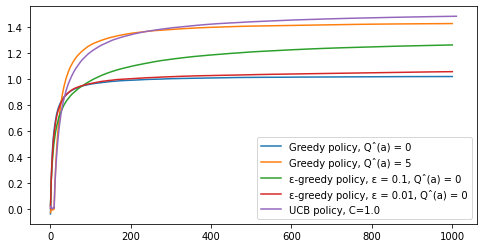

In [865]:
# 1 - Get the means of steps across the runs of a policy
# 2 - Plot each timestep across the policies

fig = plt.figure(figsize=(8, 4))

# Greedy with Q^(a) = 0
plt.plot(greedy_bandit_q0.results.index.values, greedy_bandit_q0.results.mean(axis=1))

# Greedy with Q^(a) = 5
plt.plot(greedy_bandit_q5.results.index.values, greedy_bandit_q5.results.mean(axis=1))

# Epsilon at 0.1
plt.plot(egreedy_bandit_e01.results.index.values, egreedy_bandit_e01.results.mean(axis=1))

# Epsilon at 0.01
plt.plot(egreedy_bandit_e001.results.index.values, egreedy_bandit_e001.results.mean(axis=1))

# UCB at C=1
plt.plot(ucb_bandit_1.results.index.values, ucb_bandit_1.results.mean(axis=1))

plt.legend(['Greedy policy, Qˆ(a) = 0', 
            'Greedy policy, Qˆ(a) = 5',
            'ε-greedy policy, ε = 0.1, Qˆ(a) = 0',
            'ε-greedy policy, ε = 0.01, Qˆ(a) = 0',
            'UCB policy, C=1.0'
            ])

plt.show()

## Plot the rewards received

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

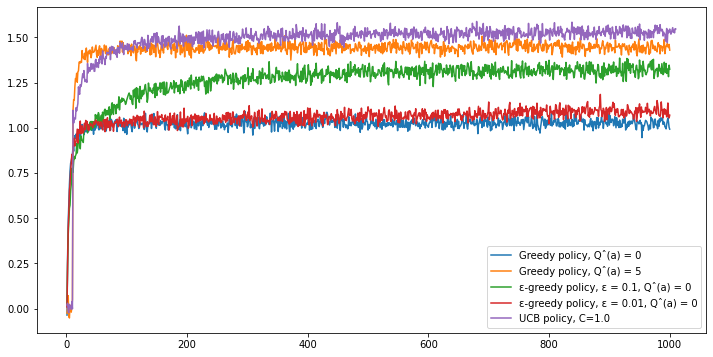

In [866]:
# 1 - Get the means of steps across the runs of a policy
# 2 - Plot each timestep across the policies

fig = plt.figure(figsize=(12, 6))

# Greedy with Q(a) = 0
plt.plot(greedy_bandit_q0.results.index.values, 
         greedy_bandit_q0.__average_results__(greedy_bandit_q0.bandit_records, 'Reward Received').mean(axis=1))

# Greedy with Q(a) = 5
plt.plot(greedy_bandit_q5.results.index.values, 
         greedy_bandit_q5.__average_results__(greedy_bandit_q5.bandit_records, 'Reward Received').mean(axis=1))

# Epsilon at 0.1
plt.plot(egreedy_bandit_e01.results.index.values, 
         egreedy_bandit_e01.__average_results__(egreedy_bandit_e01.bandit_records, 'Reward Received').mean(axis=1))

# Epsilon at 0.01
plt.plot(egreedy_bandit_e001.results.index.values, 
         egreedy_bandit_e001.__average_results__(egreedy_bandit_e001.bandit_records, 'Reward Received').mean(axis=1))

# UCB at C=0.5
plt.plot(ucb_bandit_1.results.index.values, 
         ucb_bandit_1.__average_results__(ucb_bandit_1.bandit_records, 'Reward Received').mean(axis=1))

plt.legend(['Greedy policy, Qˆ(a) = 0', 
            'Greedy policy, Qˆ(a) = 5',
            'ε-greedy policy, ε = 0.1, Qˆ(a) = 0',
            'ε-greedy policy, ε = 0.01, Qˆ(a) = 0',
            'UCB policy, C=1.0'
            ])

plt.show()